In [6]:
# To find ECD Control

import sys 
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram')


In [7]:
import numpy as np
from qutip import *
from ECD_batch_optimizerV1 import BatchOptimizer
import matplotlib.pyplot as plt


Need tf version 2.3.0 or later. Using tensorflow version: 2.7.0



In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#The target oscillator state.
N =10
Fock = 1
psi_i = tensor(basis(2,0), basis(N,0)) # initial state
psi_t = tensor(basis(2,0), basis(N,Fock)) #target state

In [10]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 4, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'initial_states' : [psi_i], #qubit tensor oscillator, start in |g> |0>
'target_states' : [psi_t], #end in |e> |target>.
'name' : 'Fock %d' % Fock, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}


#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

#### Filename for angles to be stored

In [22]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

None
Tensor("alphas:0", shape=(1, 200), dtype=complex64)
Tensor("alphas:0", shape=(4, 200), dtype=complex64)
optimization_type: state transfer
N_multistart: 200
N_blocks: 4
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: Fock 1
comment: 
user_angles: None
N_cav: 10
filename: Fock 1.h5

Best circuit parameters found:
betas:         [0.42841-0.85544j 1.05932-0.10595j 0.36594-0.72311j 0.5844 +0.14514j]
alphas:        [0.+0.j]
phis (deg):    [  0.       23.27159 126.10678 -88.95848]
thetas (deg):  [  52.97192  -96.22903 -100.24744  169.23111]
Max Fidelity:  0.413980




In [23]:
#run optimizer.
opt.optimize()

Start time: 2022-09-22 14:26:07
 Epoch: 11 / 200 Max Fid: 0.980664 Avg Fid: 0.616444 Max dFid: 0.166956 Avg dFid: 0.026397 Elapsed time: 0:00:06.532586 Remaing time: 0:01:52.241698

KeyboardInterrupt: 

In [24]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 4
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: Fock 1
comment: 
user_angles: None
N_cav: 10
filename: Fock 1.h5

Best circuit parameters found:
betas:         [ 0.1347 -1.56124j -1.00881-0.0997j   0.05268-0.65212j -0.02784+0.0035j ]
alphas:        [0.+0.j]
phis (deg):    [  0.      -87.20821 -92.46236   2.97645]
thetas (deg):  [-90.10526  89.65804  89.08682 -90.04668]
Max Fidelity:  0.981233




In [25]:
angles_filename = 'g0g1opt_angles.txt'
opt.save_angles(filename = angles_filename)

# Get Pulses

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
sys.path.append('../')
from class_description.Simulation_Classes_Single_ModeV4 import *
# Classes: ecd_pulse_single_mode to get pulses
#          , qutip_sim_single_mode to simulate on qutip

In [28]:
pulse_sim = ecd_pulse_single_mode(param_file = angles_filename,
                                 kappa = 1/(2e+6))   #T1 = 2ms

In [29]:
pulse_sim.get_pulses()

Modified method: Cond Disp Circuit
Modified conditional displacement called
---------------------------
Final Displacement: 1.5674572761408194
Modified conditional displacement called


C:\Users\Eesh Gupta\anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


---------------------------
Final Displacement: 1.013720116935186
Modified conditional displacement called
---------------------------
Final Displacement: 0.6542490539869134
Modified conditional displacement called
---------------------------
Final Displacement: 0.02805110085266306


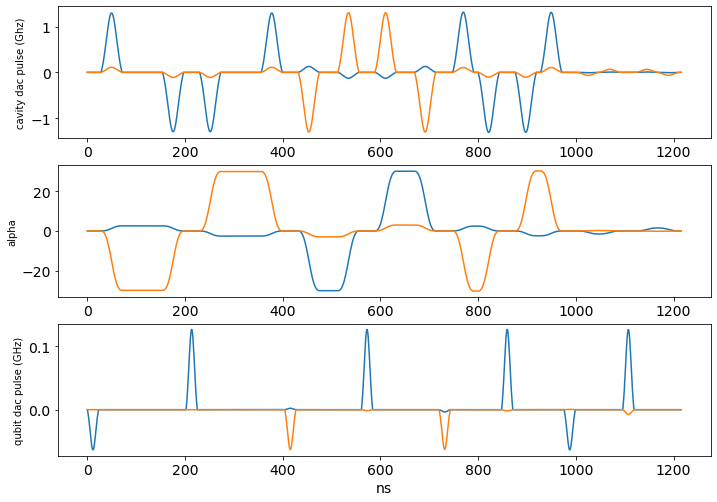

In [30]:
pulse_sim.plot_pulses()

# Qutip Simulation

In [31]:
initial = psi_i
target = psi_t

In [32]:
#Only ECD term
print('Only ECD term in Qutip')
qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
                               alpha = pulse_sim.alpha,
                               qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
                               save_states = False)
qutip_sim.me_solve(initial = initial)
ecd_fid = qutip_sim.get_fidelity(target)
print(ecd_fid)


# print('Now adding qubit-mode bare coupling')
# qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
#                                alpha = pulse_sim.alpha,
#                                qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
#                                save_states = False)
# qutip_sim.add_bare_qubit_mode_coupling()
# qutip_sim.me_solve(initial = initial)
# qm_fid = qutip_sim.get_fidelity(target)
# print(qm_fid)

# print('Now adding Stark Shifts')
# qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
#                                alpha = pulse_sim.alpha,
#                                qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
#                                save_states = False)
# qutip_sim.add_stark_shift()
# qutip_sim.me_solve(initial = initial)
# ss_fid = qutip_sim.get_fidelity(target)
# print(ss_fid)

# print('Now adding Transmon Relaxation')
# qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
#                                alpha = pulse_sim.alpha,
#                                qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
#                                save_states = False)
# qutip_sim.add_qubit_relaxation(T1 = 30e+3)
# qutip_sim.me_solve(initial = initial)
# tr_fid = qutip_sim.get_fidelity(target)
# print(tr_fid)

# print('Now adding Transmon Dephasing')
# qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
#                                alpha = pulse_sim.alpha,
#                                qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
#                                save_states = False)
# qutip_sim.add_qubit_dephasing(T1 = 30e+3, Techo = 50e+3)
# qutip_sim.me_solve(initial = initial)
# tp_fid = qutip_sim.get_fidelity(target)
# print(tp_fid)

# print('Now Adding Cavity Relaxation')
# qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
#                                alpha = pulse_sim.alpha,
#                                qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
#                                save_states = False)
# qutip_sim.add_cavity_relaxation(T1 = 2e+6)
# qutip_sim.me_solve(initial = initial)
# cr_fid = qutip_sim.get_fidelity(target)
# print(cr_fid)

print('Now Adding Cavity Dephasing')
qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
                               alpha = pulse_sim.alpha,
                               qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
                               save_states = False)
qutip_sim.add_cavity_dephasing(T1 = 2e+6, Techo = 3e+6, thermal = False)
qutip_sim.me_solve(initial = initial)
cp_fid = qutip_sim.get_fidelity(target)
print(cp_fid)

print('Now Adding Cavity Dephasing with thermal')
qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
                               alpha = pulse_sim.alpha,
                               qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
                               save_states = False)
qutip_sim.add_cavity_dephasing(T1 = 2e+6, Techo = 3e+6, thermal = True)
qutip_sim.me_solve(initial = initial)
cpt_fid = qutip_sim.get_fidelity(target)
print(cpt_fid)


Only ECD term in Qutip
(0.9804025233097936+0j)
Now Adding Cavity Dephasing
0.9612337540799738
Now Adding Cavity Dephasing with thermal
0.9592119738298852


In [33]:
qutip_sim = qutip_sim_single_mode(n_q = 2, n_c = N,
                               alpha = pulse_sim.alpha,
                               qubit_pulse = pulse_sim.qubit_dac_pulse_GHz,
                               save_states = False)
qutip_sim.add_cavity_dephasing(T1 = 2e+6, Techo = 3e+6)
qutip_sim.me_solve(initial = initial)

In [34]:
np.shape(qutip_sim.output.states[-1])

(20, 20)

In [35]:
type(qutip_sim.output.states[-1])

qutip.qobj.Qobj

# Plot

In [82]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


<ipython-input-90-e53dcb8d97eb>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(conditions, fontsize = 15)


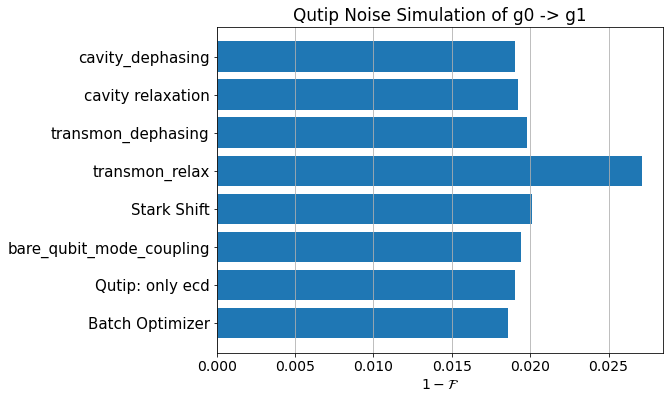

In [90]:
conditions = ['Batch Optimizer', 'Qutip: only ecd', 
              'bare_qubit_mode_coupling','Stark Shift',
               'transmon_relax','transmon_dephasing',
             'cavity relaxation', 'cavity_dephasing']
x_pos = np.arange(len(conditions))
bars = [opt.best_fidelity(), ecd_fid, qm_fid, ss_fid,
       np.sqrt(tr_fid), np.sqrt(tp_fid), np.sqrt(cr_fid), np.sqrt(cp_fid)]
bars_inv = [1- i for i in bars]

fig, ax = plt.subplots(figsize = (8,6))
ax.barh(conditions, bars_inv, align='center')
ax.set_xlabel('$1-\mathcal{F}$')
#ax.set_xticks(x_pos)
ax.set_yticklabels(conditions, fontsize = 15)
ax.set_title('Qutip Noise Simulation of g0 -> g1')
ax.xaxis.grid(True)
#plt.yticks(range(len(conditions)), conditions, rotation = 90)

<ipython-input-100-41e46397413f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(conditions, fontsize = 15)


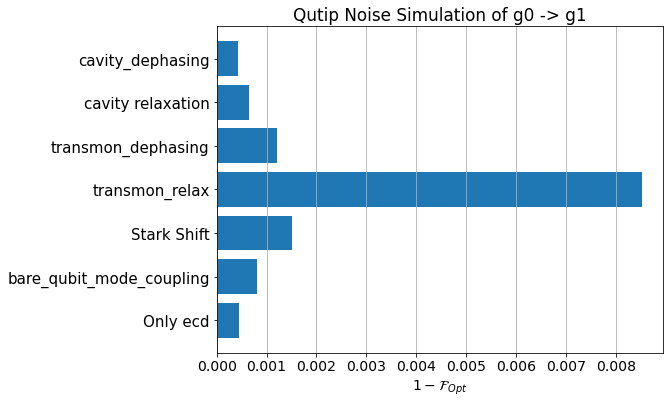

In [100]:
conditions = ['Only ecd', 
              'bare_qubit_mode_coupling','Stark Shift',
               'transmon_relax','transmon_dephasing',
             'cavity relaxation', 'cavity_dephasing']
x_pos = np.arange(len(conditions))
bars = [ ecd_fid, qm_fid, ss_fid,
       np.sqrt(tr_fid), np.sqrt(tp_fid), np.sqrt(cr_fid), np.sqrt(cp_fid)]
bars = [opt.best_fidelity() - i for i in bars]
#bars_inv = [1- i for i in bars]

fig, ax = plt.subplots(figsize = (8,6))
ax.barh(conditions, bars, align='center')
ax.set_xlabel('$1-\mathcal{F}_{Opt}$')
#ax.set_xticks(x_pos)
ax.set_yticklabels(conditions, fontsize = 15)
ax.set_title('Qutip Noise Simulation of g0 -> g1')
ax.xaxis.grid(True)
#plt.yticks(range(len(conditions)), conditions, rotation = 90)